## 1. Load Dataset and Filter Prescribed Burns

In this step, we load the cleaned fire dataset (`all_fires.csv`) that was generated in Milestone 2.  
We then filter the records to include only **prescribed burns**, which are marked in the dataset as `CAUSE == "H-PB"`.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from explore_utils import summarize_by_province_for_range

# Load cleaned fire dataset
df = pd.read_csv("../1_datasets/all_fires.csv")

# Filter only prescribed burns
prescribed = df[df["cause"] == "H-PB"].copy()

print(f"Total fire records: {df.shape[0]}")
print(f"Prescribed burns: {prescribed.shape[0]}")
prescribed.head()

/var/folders/cr/_3swsj_161s3334l9q8zv_d40000gn/T/ipykernel_6177/673447685.py:5: DtypeWarning: Columns (9,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../1_datasets/all_fires.csv")


Total fire records: 442403
Prescribed burns: 353


,nfdbfireid,src_agency,fire_id,latitude,longitude,year,month,day,rep_date,out_date,size_ha,cause,fire_type,prescribed
3926,NT-2000-HYP01-00,NT,HYP01-00,61.6000,-117.2000,2000,6,10,2000-06-10,2000-07-01,17.8,H-PB,NaN,PB
6578,NT-1993-HYP01-93,NT,HYP01-93,61.3166,-116.9666,1993,5,14,1993-05-14,1993-05-19,3400.0,H-PB,NaN,PB
6622,NT-1993-SMP01-93,NT,SMP01-93,60.7166,-112.7500,1993,5,14,1993-05-14,1993-05-16,4000.0,H-PB,NaN,PB
6985,NT-1994-HYP01-94,NT,HYP01-94,61.5166,-117.2333,1994,5,4,1994-05-04,1994-05-05,1123.0,H-PB,NaN,PB
6986,NT-1994-HYP02-94,NT,HYP02-94,61.5166,-118.1333,1994,5,5,1994-05-05,1994-05-11,2805.0,H-PB,NaN,PB


## 2. Explore Prescribed Burns Per Province

This section groups the prescribed burns by `src_agency` (often representing province or territory).  
We count how many prescribed burns have been reported by each province and visualize the results in a bar chart.


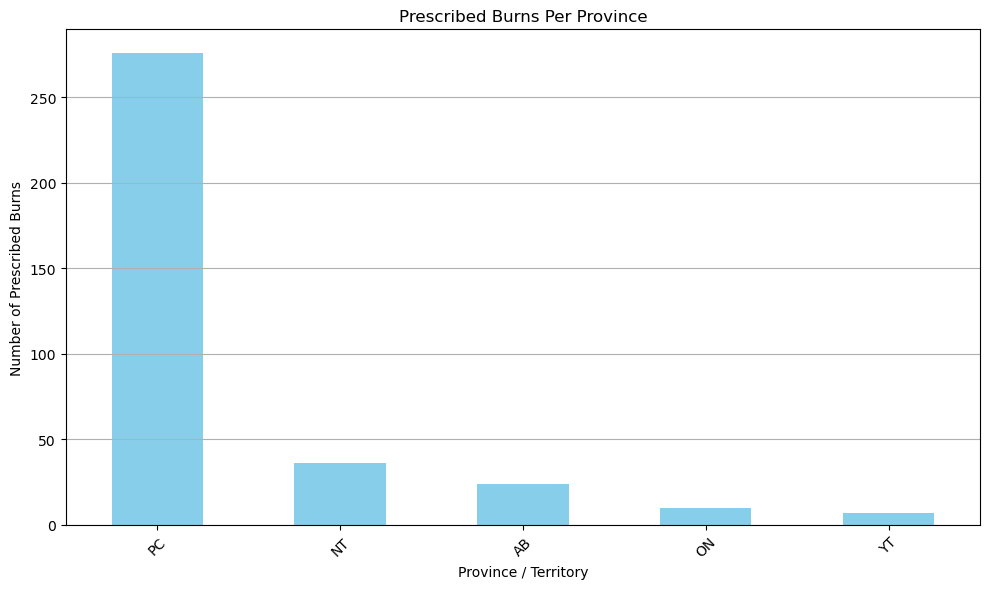

src_agency
PC    276
NT     36
AB     24
ON     10
YT      7
Name: count, dtype: int64

In [5]:
# Group by reporting agency (typically province)
burns_by_province = prescribed["src_agency"].value_counts().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 6))
burns_by_province.plot(kind="bar", color="skyblue")
plt.title("Prescribed Burns Per Province")
plt.xlabel("Province / Territory")
plt.ylabel("Number of Prescribed Burns")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

burns_by_province

## Why `src_agency` is Misleading (PC = Parks Canada)

The NFDB `src_agency` field can be a province/territory **or** a federal agency such as **PC (Parks Canada)**.  
Because Parks Canada operates in multiple provinces, grouping by `src_agency` overcounts "PC" and does **not** 
tell us which provinces truly have the most prescribed burns.

**Solution:** We assign each burn to a real province using a spatial join (point-in-polygon):
## Steps 
1) Download a lightweight Canada provinces boundary file.
2) Ensure it uses WGS84 (EPSG:4326) to match our latitude/longitude.
3) Convert each burn to a `Point(lon, lat)` geometry.
4) Spatially join points to province polygons to create a new `province` column.
5) Recreate the bar chart + exports using `province` instead of `src_agency`.


### Download & Prepare Canada Provinces (Natural Earth)

We fetch the public-domain **Natural Earth** Admin-1 (states/provinces) dataset (1:50m scale),  
filter to **Canada**, ensure **WGS84 / EPSG:4326**, and save a compact GeoJSON to:

`1_datasets/boundaries/canada_provinces.geojson`

Key fields we’ll use later:
- `name`   → province/territory name (e.g., "Alberta")
- `postal` → two-letter code (e.g., "AB")


In [6]:
import os
import io
import zipfile
import requests
import geopandas as gpd

BOUNDARY_DIR = "../1_datasets/boundaries"
os.makedirs(BOUNDARY_DIR, exist_ok=True)
OUT_GEOJSON = os.path.join(BOUNDARY_DIR, "canada_provinces.geojson")

if os.path.exists(OUT_GEOJSON):
    print(f"Found existing: {OUT_GEOJSON}")
else:
    url = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces.zip"
    print("Downloading Natural Earth Admin-1 (states/provinces)...")
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()

    tmp_dir = os.path.join(BOUNDARY_DIR, "_tmp_ne50")
    os.makedirs(tmp_dir, exist_ok=True)
    with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
        z.extractall(tmp_dir)

    shp_path = os.path.join(tmp_dir, "ne_50m_admin_1_states_provinces.shp")
    adm1 = gpd.read_file(shp_path)
    canada = adm1[adm1["admin"] == "Canada"].copy()

    keep_cols = [
        c
        for c in [
            "name",
            "name_en",
            "name_fr",
            "postal",
            "type_en",
            "adm1_code",
            "geometry",
        ]
        if c in canada.columns
    ]
    canada = canada[keep_cols]

    if canada.crs is None or canada.crs.to_epsg() != 4326:
        canada = canada.to_crs(4326)

    canada.to_file(OUT_GEOJSON, driver="GeoJSON")
    print(f"Saved: {OUT_GEOJSON}")

# quick peek at columns to decide which to use as province label
canada_preview = gpd.read_file(OUT_GEOJSON)
print("Boundary columns:", list(canada_preview.columns))
canada_preview.head(2)

Saved: ../1_datasets/boundaries/canada_provinces.geojson
Boundary columns: ['name', 'name_en', 'name_fr', 'postal', 'type_en', 'adm1_code', 'geometry']


,name,name_en,name_fr,postal,type_en,adm1_code,geometry
0,Alberta,Alberta,Alberta,AB,Province,CAN-632,"POLYGON ((-109.99943 48.99308, -110.3213 48.99..."
1,British Columbia,British Columbia,Colombie-Britannique,BC,Province,CAN-633,"MULTIPOLYGON (((-120.00001 60.00109, -120.0000..."


### Spatial Join (Point-in-Polygon) to Assign Provinces

We convert prescribed burns to geometric points (`Point(longitude, latitude)`),  
ensure both layers share the same CRS (**EPSG:4326**), and perform a spatial join:

  

In [7]:
from shapely.geometry import Point


# 1) Load boundaries and ensure EPSG:4326
provinces = gpd.read_file(OUT_GEOJSON)
if provinces.crs is None or provinces.crs.to_epsg() != 4326:
    provinces = provinces.to_crs(4326)

# 2) Build point GeoDataFrame from prescribed burns
#    IMPORTANT: geometry Point(x, y) = Point(lon, lat)
prescribed_pts = gpd.GeoDataFrame(
    prescribed.copy(),
    geometry=[Point(xy) for xy in zip(prescribed["longitude"], prescribed["latitude"])],
    crs="EPSG:4326",
)

# 3) `predicate="within"` → each point must lie inside a province polygon
joined = gpd.sjoin(prescribed_pts, provinces, how="left", predicate="within")

# 4) Decide which boundary column to use for labeling provinces
province_col_in_file = "name"
joined = joined.rename(columns={province_col_in_file: "province"})

# quick QA
missing_prov = joined["province"].isna().sum()
print(
    f"Rows without a province match: {missing_prov} (likely near borders or invalid coords)"
)
joined[["nfdbfireid", "src_agency", "province", "year", "latitude", "longitude"]].head()

Rows without a province match: 36 (likely near borders or invalid coords)


,nfdbfireid,src_agency,province,year,latitude,longitude
3926,NT-2000-HYP01-00,NT,Northwest Territories,2000,61.6000,-117.2000
6578,NT-1993-HYP01-93,NT,Northwest Territories,1993,61.3166,-116.9666
6622,NT-1993-SMP01-93,NT,Northwest Territories,1993,60.7166,-112.7500
6985,NT-1994-HYP01-94,NT,Northwest Territories,1994,61.5166,-117.2333
6986,NT-1994-HYP02-94,NT,Northwest Territories,1994,61.5166,-118.1333


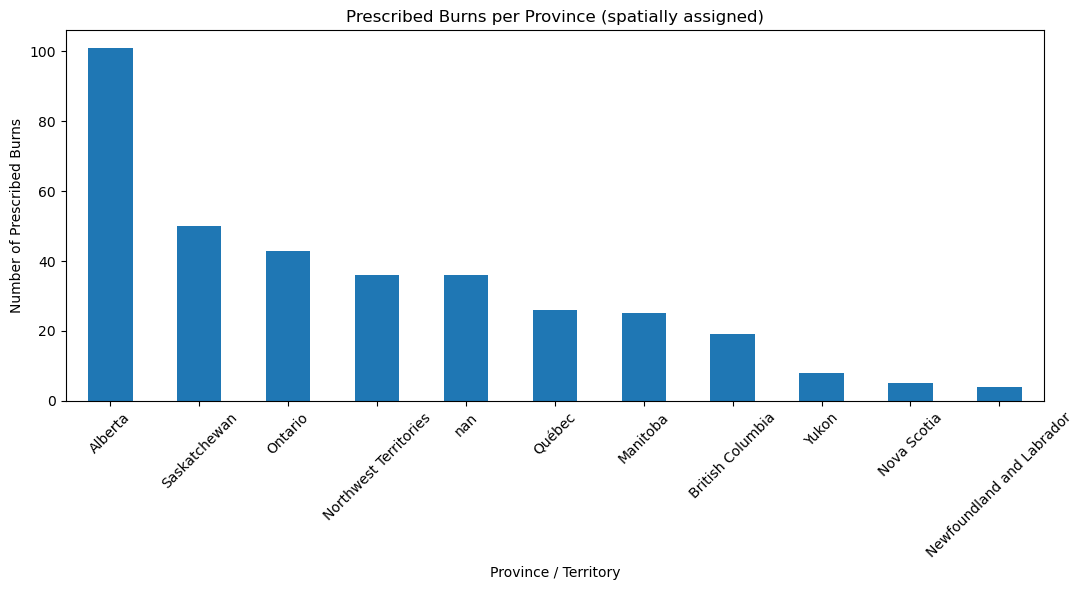

province
Alberta                      101
Saskatchewan                  50
Ontario                       43
Northwest Territories         36
NaN                           36
Québec                        26
Manitoba                      25
British Columbia              19
Yukon                          8
Nova Scotia                    5
Newfoundland and Labrador      4
Name: count, dtype: int64

In [8]:
burns_by_province_true = (
    joined["province"].value_counts(dropna=False).sort_values(ascending=False)
)

plt.figure(figsize=(11, 6))
burns_by_province_true.plot(kind="bar")
plt.title("Prescribed Burns per Province (spatially assigned)")
plt.xlabel("Province / Territory")
plt.ylabel("Number of Prescribed Burns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

burns_by_province_true

## Comparison: 2005–2015 vs 2015–2025

Here we compare prescribed burns per province for two recent decades:
- **2005–2015**
- **2015–2025**

This helps us identify which province has the most prescribed burns reported within the recent decades.

,count
province,
Alberta,64
Saskatchewan,31
NaN,23
Manitoba,17
Québec,11
Ontario,10
British Columbia,9
Newfoundland and Labrador,4
Nova Scotia,2


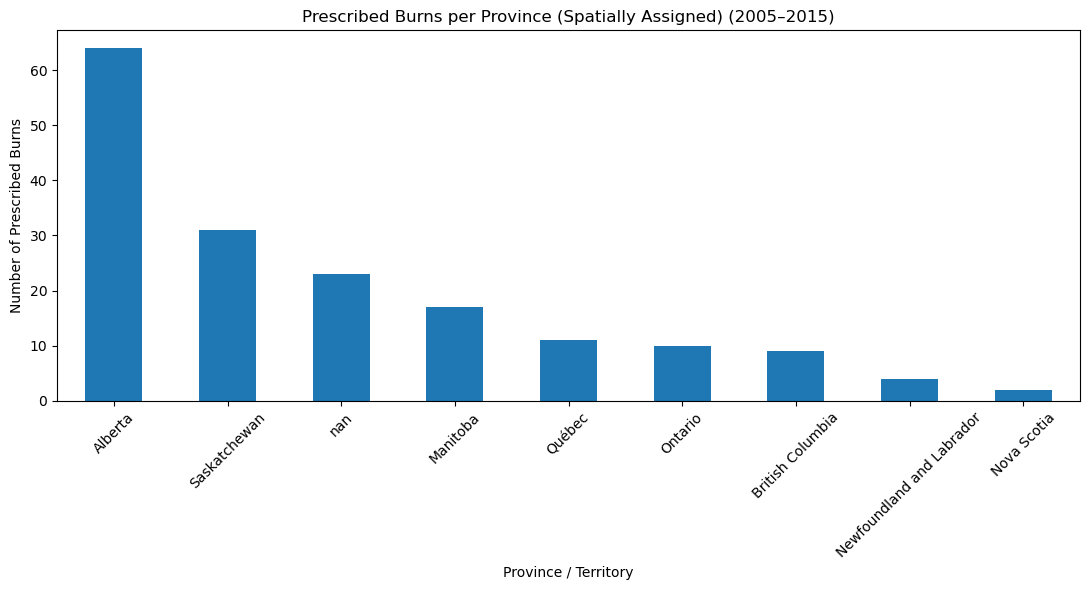

,count
province,
Alberta,39
Ontario,35
Saskatchewan,24
NaN,23
Québec,17
British Columbia,11
Manitoba,10
Yukon,8
Nova Scotia,3


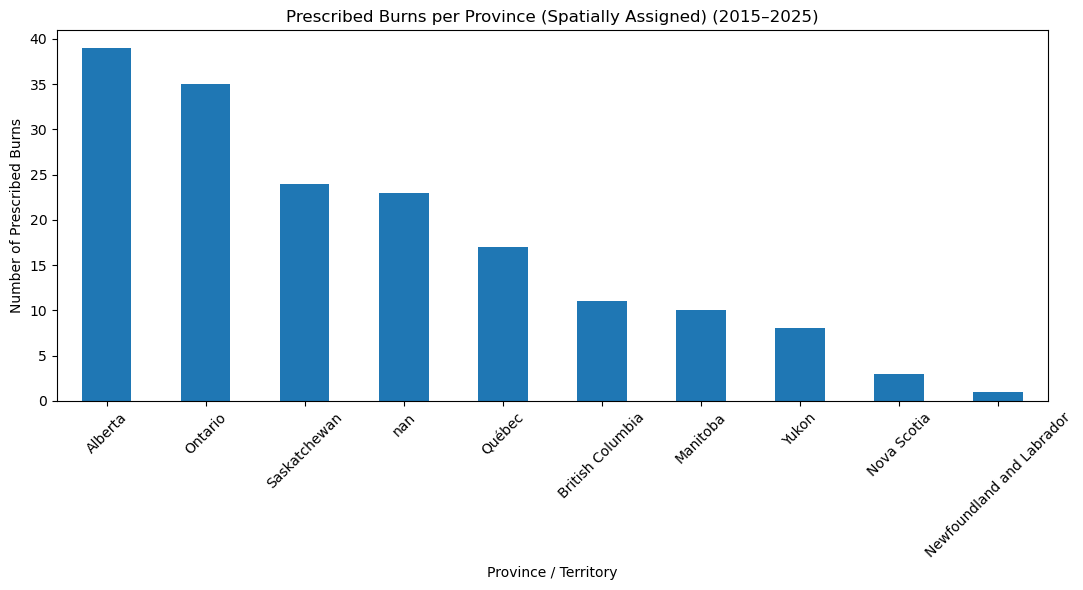

,2005–2015,2015–2025
province,,
Alberta,64,39
Ontario,10,35
Saskatchewan,31,24
NaN,23,23
Québec,11,17
British Columbia,9,11
Manitoba,17,10
Yukon,0,8
Nova Scotia,2,3


<Figure size 1000x600 with 0 Axes>

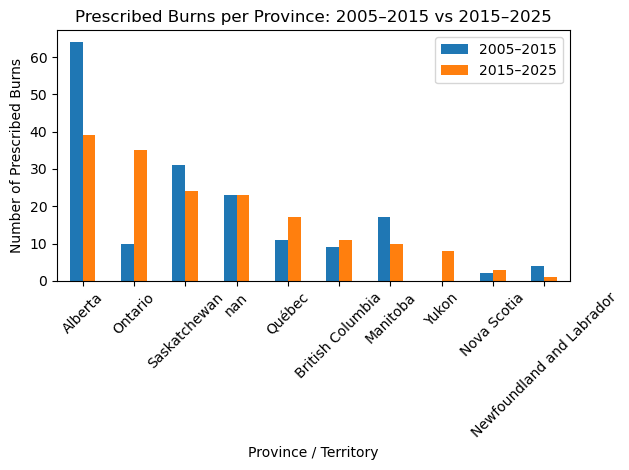

In [12]:
# Generate counts for each custom time span
counts_2005_2015 = summarize_by_province_for_range(
    joined, 2005, 2015, top_n=None, title_suffix="(Spatially Assigned)"
)
counts_2015_2025 = summarize_by_province_for_range(
    joined, 2015, 2025, top_n=None, title_suffix="(Spatially Assigned)"
)

# Combine into a comparison DataFrame
comp_custom = (
    pd.DataFrame({"2005–2015": counts_2005_2015, "2015–2025": counts_2015_2025})
    .fillna(0)
    .astype(int)
    .sort_values(by="2015–2025", ascending=False)
)

display(comp_custom)

# Plot top K provinces
K = 10
comp_custom_top = comp_custom.head(K)

plt.figure(figsize=(10, 6))
comp_custom_top.plot(kind="bar")
plt.title("Prescribed Burns per Province: 2005–2015 vs 2015–2025")
plt.xlabel("Province / Territory")
plt.ylabel("Number of Prescribed Burns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Export Prescribed Burns per Province for 2005–2015 and 2015–2025

We now export one CSV file for each province for both selected time ranges:
- `prescribed_burns_by_province_2005_2015/`
- `prescribed_burns_by_province_2015_2025/`

Each CSV contains only the prescribed burns that occurred in that province during the given range.


In [14]:
# Ensure 'year' is numeric
joined["year"] = pd.to_numeric(joined["year"], errors="coerce")

# Base columns to keep
cols_keep = [
    "nfdbfireid",
    "src_agency",
    "province",
    "year",
    "month",
    "day",
    "rep_date",
    "out_date",
    "size_ha",
    "cause",
    "latitude",
    "longitude",
]

# Define the time spans
custom_ranges = {"2005_2015": (2005, 2015), "2015_2025": (2015, 2025)}

# Loop through each range and export per province
for label, (start, end) in custom_ranges.items():
    out_dir = f"../1_datasets/prescribed_burns_by_province_{label}/"
    os.makedirs(out_dir, exist_ok=True)

    # Filter to the time range
    range_df = joined[(joined["year"] >= start) & (joined["year"] <= end)]

    for prov in sorted(range_df["province"].dropna().unique()):
        prov_df = range_df[range_df["province"] == prov][cols_keep]
        file_path = os.path.join(out_dir, f"{prov}_prescribed_burns_{label}.csv")
        prov_df.to_csv(file_path, index=False)
        print(f"Saved: {file_path} ({prov_df.shape[0]} records)")

Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Alberta_prescribed_burns_2005_2015.csv (64 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/British Columbia_prescribed_burns_2005_2015.csv (9 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Manitoba_prescribed_burns_2005_2015.csv (17 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Newfoundland and Labrador_prescribed_burns_2005_2015.csv (4 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Nova Scotia_prescribed_burns_2005_2015.csv (2 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Ontario_prescribed_burns_2005_2015.csv (10 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Québec_prescribed_burns_2005_2015.csv (11 records)
Saved: ../1_datasets/prescribed_burns_by_province_2005_2015/Saskatchewan_prescribed_burns_2005_2015.csv (31 records)
Saved: ../1_datasets/prescribed_burns_by_province_2015_2025/Alberta_pre